# <font color=black> Analysis - ICA vs iCAP in the spinal cord </font>
<hr style="border:1px solid black">

**The goal of this analysis is to investigate the reproducibility of spinal networks extracted using different methods and datasets.**

**METHODS CONSIDERED:**
- Independent Component Analysis – called `ica` in this script
- Innovation-driven CoActivation Pattern analysis – called `icap` in this script

**DATASETS:**
- A dataset covering C1 to C8 spinal levels, with a resolution of 1.6x1.6x4mm<sup>3</sup>  and a TR of 1.55s – called `mtl` in this script
- A dataset covering C5 to C8 spinal levels, with a resolution of 1x1x3mm<sup>3</sup> and a TR of 2.5s – called `gva` in this script

**ANALYSES:**
- _**Qualitative:**_ matching & visualization of one or two set(s) of components
- _**Quantitative:**_
    * Analysis of spatial similarity (for a single K, or across multiple Ks)
    * Distribution across axial subdvisions (D,V,L,R) for different Ks

In [89]:
import sys,json
import glob
import pandas as pd
import numpy as np
import nibabel as nib
import seaborn as sns

sys.path.append('/media/miplab-nas2/Data3/BMPD/hc_project/analysis/code/')
#sys.path.append('/cerebro/cerebro1/dataset/bmpd/derivatives/HealthyControls_project/hc_project_analyses/code/')

from plotting import Plotting
from spine_only_analysis import SpineOnlyAnalysis
from compute_similarity import compute_similarity

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<hr style="border:1px solid black">

# Initialization

### Load configuration file 

In [69]:
# Load the config files with all informations (i.e., all datasets, methods, etc.)
with open('../config/config_spine_only_NK.json') as config_file:
    config = json.load(config_file)
    
#with open('../config/config_spine_only_CL.json') as config_file:
#    config = json.load(config_file)
    

<hr style="border:1px solid black">

# Figure 1 – Defining number of components

## Stability across subsampling
Here, we take 100 subsamples of 10 subjects and assess the similarity with respect to the entire group

In [111]:
# Initializing parameters
methods = ['ica','icap']
datasets = ['gva','mtl']
nperm = 100

# Create structure to save results
all_methods = []
all_datasets = []
all_kmax = []
all_sim = []
all_n = []
# For each method & dataset
for method in methods:
    for dataset in datasets:
        krange = range(7,12) if dataset == 'mtl' else range(3,8)
        print(f'Computing stability for {method} in {dataset}')
        # Looping through K and permutations
        for k_i,kmax in enumerate(krange):
            print(f'K = {kmax}')
             # Load reference data (entire group)
            data_ref = nib.load(glob.glob(config['main_dir']+config['data'][dataset][method]['spinalcord']['dir'] + '/K_' + str(kmax) + '/comp_zscored/*' + config['data'][dataset][method]['spinalcord']["tag_filename"] + '*')[0]).get_fdata()
            for n in range(0,nperm):
                all_methods.append(method)
                all_datasets.append(dataset)
                all_kmax.append(kmax)
                all_n.append(n)
                # Load permutation data
                data_perm = nib.load(glob.glob(config['main_dir']+config['data'][dataset][method + '_perm']['spinalcord']['dir'] + str(n+1) + '*/K_' + str(kmax) + '*/' + config['data'][dataset][method + '_perm']['spinalcord']['comp_folder'] + '/*' + config['data'][dataset][method + '_perm']['spinalcord']["tag_filename"] + '*.nii*')[0]).get_fdata()            
                # Compute similarity matrix between perm data and ref 
                [tmp_mat,_,_] = compute_similarity(config,data_ref,data_perm,thresh1=1.6,thresh2=1.6,verbose=False)
                # Take mean of the diagonal as a summary measure of similarity
                all_sim.append(np.mean(np.diag(tmp_mat)))
colnames = ["method","dataset","kmax","perm","sim"]
perm_df = pd.DataFrame(list(zip(all_methods, all_datasets, all_kmax, all_n, all_sim)), columns=colnames)

Computing stability for ica in gva
K = 3
K = 4
K = 5
K = 6
K = 7
Computing stability for ica in mtl
K = 7
K = 8
K = 9
K = 10
K = 11
Computing stability for icap in gva
K = 3
K = 4
K = 5
K = 6
K = 7
Computing stability for icap in mtl
K = 7
K = 8
K = 9
K = 10
K = 11


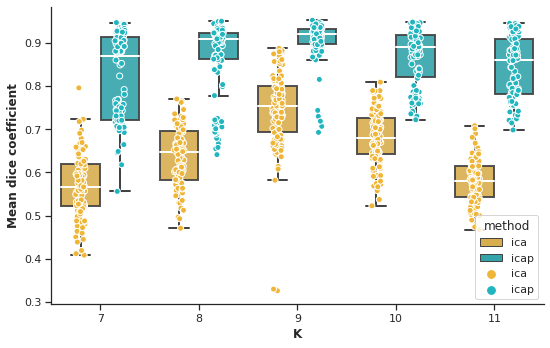

In [157]:
dataset='mtl'
colors=['#efb537','#20b5bf'] #'#273248'
sns.set(style="ticks",  font='sans-serif')
g=sns.catplot(y="sim",x="kmax",data=perm_df[perm_df['dataset']==dataset], kind="box", hue="method", legend=True, legend_out=True,
             linewidth=2,medianprops=dict(color="white"),palette=colors, 
            boxprops=dict(alpha=.9),fliersize=0, aspect=1) #fliersize=0)
g.fig.set_size_inches(10,5)

sns.stripplot(y="sim",x="kmax",data=perm_df[perm_df['dataset']==dataset], hue="method",
             size=6, palette=colors, alpha=1, linewidth=1,edgecolor='white',dodge=True)
g._legend.remove()
g.set_axis_labels("K", "Mean dice coefficient",fontsize=12, fontweight='bold')

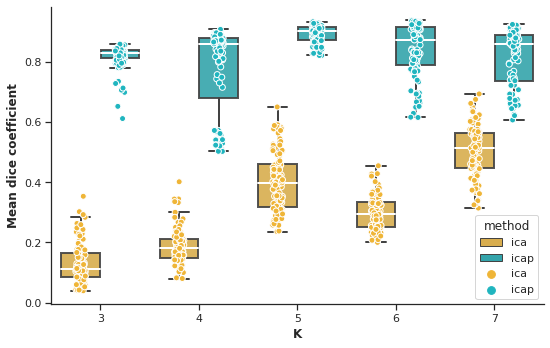

In [158]:
dataset='gva'
colors=['#efb537','#20b5bf'] #'#273248'
sns.set(style="ticks",  font='sans-serif')
g=sns.catplot(y="sim",x="kmax",data=perm_df[perm_df['dataset']==dataset], kind="box", hue="method", legend=True, legend_out=True,
             linewidth=2,medianprops=dict(color="white"),palette=colors, 
            boxprops=dict(alpha=.9),fliersize=0, aspect=1) #fliersize=0)
g.fig.set_size_inches(10,5)

sns.stripplot(y="sim",x="kmax",data=perm_df[perm_df['dataset']==dataset], hue="method",
             size=6, palette=colors, alpha=1, linewidth=1,edgecolor='white',dodge=True)
g._legend.remove()
g.set_axis_labels("K", "Mean dice coefficient",fontsize=12, fontweight='bold')

<hr style="border:1px solid black">

# Figure 2 – Robustness (across methods)

## `GVA` dataset

### Qualitative evaluation

In [ ]:
# Define parameters for the dataset to visualize
# Note: it is possible to look at a single dataset (in that case, just define params1), or to compare two (in that case, also add params2)
# Each param dict has 3 values: k, dataset and analysis
params_qual_robustness_gva_ica = {'k':5, 'dataset':'gva', 'analysis':'ica', 'lthresh':1.6}
params_qual_robustness_gva_icap = {'k':5, 'dataset':'gva', 'analysis':'icap', 'lthresh':1.6}

plotting_robustness_gva = Plotting(config,'spinalcord',params1=params_qual_robustness_gva_ica,params2=params_qual_robustness_gva_icap)

In [ ]:
#plotting_robustness_gva.sc_plot(show_spinal_levels=False, k_per_line=5, lthresh=1.6, uthresh=3.5, save_results=True, similarity_method='Dice', template=config['main_dir']+'/templates/PAM50_hc_project/template/T2w_gva_group_mean_resampled.nii.gz')
plotting_robustness_gva.sc_plot(show_spinal_levels=False, k_per_line=5, lthresh=1.6, uthresh=3.5, save_results=True, similarity_method='Dice')


_Note: the component numbers refer to the ones of the original datasets (i.e., before any type of reordering)_

### Quantitative evaluation - Number of voxels & Dice

In [ ]:
# Define parameters for the datasets to compare
# Each param dict has 3 values: k_range, dataset and analysis
params_quant_robustness_gva_ica = {'k_range':range(5,6), 'dataset':'gva', 'analysis':'ica', 'lthresh':1.6}
params_quant_robustness_gva_icap = {'k_range':range(5,6), 'dataset':'gva', 'analysis':'icap', 'lthresh':1.6}

spine_analysis_robustness_gva = SpineOnlyAnalysis(config,params1=params_quant_robustness_gva_ica,params2=params_quant_robustness_gva_icap)

In [ ]:
spine_analysis_robustness_gva.extract_voxels_nb(K=5,params=params_quant_robustness_gva_ica) 
spine_analysis_robustness_gva.extract_voxels_nb(K=5,params=params_quant_robustness_gva_icap) 

In [ ]:
# Similarity has been computed using 'Dice', but 'Cosine' or 'Euclidean distance' could be used instad
spine_analysis_robustness_gva.spatial_similarity(k1=5,similarity_method='Dice',save_figure=True)

## `MTL` dataset

### Qualitative evaluation

In [ ]:
# Define parameters for the dataset to visualize
# Note: it is possible to look at a single dataset (in that case, just define params1), or to compare two (in that case, also add params2)
# Each param dict has 3 values: k, dataset and analysis
params_qual_robustness_mtl_ica = {'k':10, 'dataset':'mtl', 'analysis':'ica', 'lthresh':1.6}
params_qual_robustness_mtl_icap = {'k':10, 'dataset':'mtl', 'analysis':'icap', 'lthresh':1.6}

plotting_robustness_mtl = Plotting(config,'spinalcord',params1=params_qual_robustness_mtl_ica,params2=params_qual_robustness_mtl_icap)

In [ ]:
#plotting_robustness_mtl.sc_plot(show_spinal_levels=False, k_per_line=9, lthresh=1.6, uthresh=3.5, save_results=True, similarity_method='Dice', template=config['main_dir']+'/templates/PAM50_hc_project/template/T2w_mtl_group_mean_resampled.nii.gz')
plotting_robustness_mtl.sc_plot(show_spinal_levels=False, k_per_line=10, lthresh=1.6, uthresh=3.5, save_results=True, similarity_method='Dice')

_Note: the component numbers refer to the ones of the original datasets (i.e., before any type of reordering)_

### Quantitative evaluation

In [ ]:
# Define parameters for the datasets to compare
# Each param dict has 3 values: k_range, dataset and analysis
params_quant_robustness_mtl_ica = {'k_range':range(9,10), 'dataset':'mtl', 'analysis':'ica', 'lthresh':1.6}
params_quant_robustness_mtl_icap = {'k_range':range(9,10), 'dataset':'mtl', 'analysis':'icap', 'lthresh':1.6}

spine_analysis_robustness_mtl = SpineOnlyAnalysis(config,params1=params_quant_robustness_mtl_ica,params2=params_quant_robustness_mtl_icap)

In [ ]:
spine_analysis_robustness_mtl.extract_voxels_nb(K=9,params=params_quant_robustness_mtl_icap) 
spine_analysis_robustness_mtl.extract_voxels_nb(K=9,params=params_quant_robustness_mtl_ica) 

In [ ]:
# Similarity has been computed using 'Dice', but 'Cosine' or 'Euclidean distance' could be used instad
spine_analysis_robustness_mtl.spatial_similarity(k1=9,similarity_method='Dice',save_figure=True)

<hr style="border:1px solid black">

# Figure 3 – Replicability (across datasets)

## `ICA` method

### Qualitative evaluation

In [109]:
# Define parameters for the dataset to visualize
# Note: it is possible to look at a single dataset (in that case, just define params1), or to compare two (in that case, also add params2)
# Each param dict has 3 values: k, dataset and analysis
params_qual_replic_ica_gva = {'k':5, 'dataset':'gva', 'analysis':'ica', 'lthresh':1.6}
params_qual_replic_ica_mtl = {'k':5, 'dataset':'gva', 'analysis':'icap', 'lthresh':1.6}

plotting_replicability_ica = Plotting(config,'spinalcord',params1=params_qual_replic_ica_gva,params2=params_qual_replic_ica_mtl)

Sorting method: rostrocaudal (max value)
Sorting method: rostrocaudal (max value)


The plotting will be displayed in neurological orientation (Left > Right)
COMPUTING SIMILARITY WITH METHOD: Dice
...Compute similarity between pairs of components
...Ordering components based on maximum weight matching
DONE!


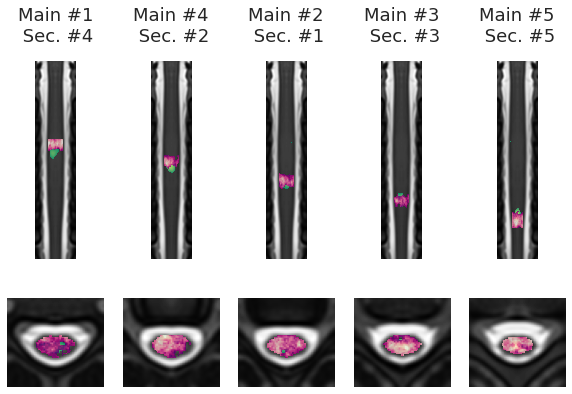

In [110]:
plotting_replicability_ica.sc_plot(show_spinal_levels=False, k_per_line=5, lthresh=1.6, uthresh=3.5, save_results=True, colormap_two=['summer','RdPu_r'], similarity_method='Dice', centering_method='middle')

In [ ]:
# Define parameters for the dataset to visualize
# Note: it is possible to look at a single dataset (in that case, just define params1), or to compare two (in that case, also add params2)
# Each param dict has 3 values: k, dataset and analysis
params_qual_replic_ica_gva = {'k':5, 'dataset':'gva', 'analysis':'ica', 'lthresh':1.6}
params_qual_replic_ica_mtl = {'k':9, 'dataset':'mtl', 'analysis':'ica', 'lthresh':1.6}

plotting_replicability_ica = Plotting(config,'spinalcord',params1=params_qual_replic_ica_gva,params2=params_qual_replic_ica_mtl)

In [ ]:
plotting_replicability_ica.sc_plot(show_spinal_levels=False, k_per_line=9, lthresh=1.6, uthresh=3.5, save_results=True, colormap_two=['summer','RdPu_r'], similarity_method='Dice', centering_method='middle')

_Note: the component numbers refer to the ones of the original datasets (i.e., before any type of reordering)_

### Quantitative evaluation

In [ ]:
# Define parameters for the datasets to compare
# Each param dict has 3 values: k_range, dataset and analysis
params_quant_replicability_ica_gva = {'k_range':range(5,6), 'dataset':'gva', 'analysis':'ica', 'lthresh':1.6}
params_quant_replicability_ica_mtl = {'k_range':range(9,10), 'dataset':'mtl', 'analysis':'ica', 'lthresh':1.6}

spine_analysis_replicability_ica = SpineOnlyAnalysis(config,params1=params_quant_replicability_ica_gva,params2=params_quant_replicability_ica_mtl)

In [ ]:
# Similarity has been computed using 'Dice', but 'Cosine' or 'Euclidean distance' could be used instad
spine_analysis_replicability_ica.spatial_similarity(k1=5,k2=9,similarity_method='Dice',save_figure=True)

## `iCAP` method

### Qualitative evaluation

In [ ]:
# Define parameters for the dataset to visualize
# Note: it is possible to look at a single dataset (in that case, just define params1), or to compare two (in that case, also add params2)
# Each param dict has 3 values: k, dataset and analysis
params_qual_replic_icap_gva = {'k':5, 'dataset':'gva', 'analysis':'icap', 'lthresh':1.6}
params_qual_replic_icap_mtl = {'k':9, 'dataset':'mtl', 'analysis':'icap', 'lthresh':1.6}

plotting_replicability_icap = Plotting(config,'spinalcord',params1=params_qual_replic_icap_gva,params2=params_qual_replic_icap_mtl)

In [ ]:
plotting_replicability_icap.sc_plot(show_spinal_levels=False, k_per_line=9, lthresh=1.6, uthresh=3.5, save_results=True, colormap_two=['summer','RdPu_r'], similarity_method='Dice', centering_method='middle')

_Note: the component numbers refer to the ones of the original datasets (i.e., before any type of reordering)_

### Quantitative evaluation

In [ ]:
# Define parameters for the datasets to compare
# Each param dict has 3 values: k_range, dataset and analysis
params_quant_replicability_icap_gva = {'k_range':range(5,6), 'dataset':'gva', 'analysis':'icap', 'lthresh':1.6}
params_quant_replicability_icap_mtl = {'k_range':range(9,10), 'dataset':'mtl', 'analysis':'icap', 'lthresh':1.6}

spine_analysis_replicability_icap = SpineOnlyAnalysis(config,params1=params_quant_replicability_icap_gva,params2=params_quant_replicability_icap_mtl)

In [ ]:
# Similarity has been computed using 'Dice', but 'Cosine' or 'Euclidean distance' could be used instad
spine_analysis_replicability_icap.spatial_similarity(k1=5,k2=9,similarity_method='Dice',save_figure=True)

<hr style="border:1px solid black">

# Figure 4 – Stability across splits

## `GVA` dataset

### Qualitative evaluation

Sorting method: rostrocaudal (max value)
The plotting will be displayed in neurological orientation (Left > Right)
Sorting method: rostrocaudal (max value)
The plotting will be displayed in neurological orientation (Left > Right)
Sorting method: rostrocaudal (max value)
The plotting will be displayed in neurological orientation (Left > Right)
Sorting method: rostrocaudal (max value)
The plotting will be displayed in neurological orientation (Left > Right)


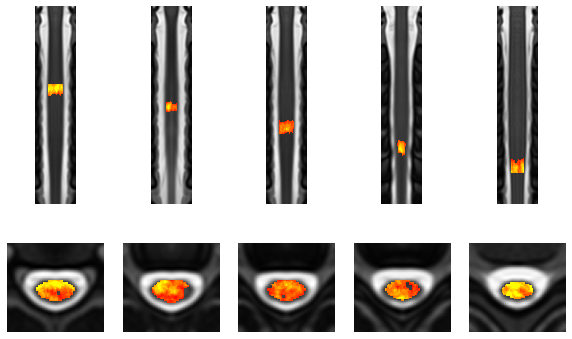

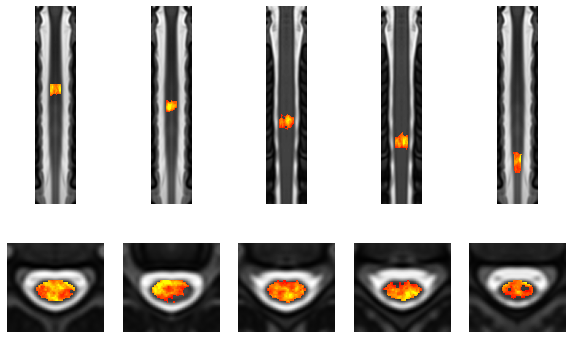

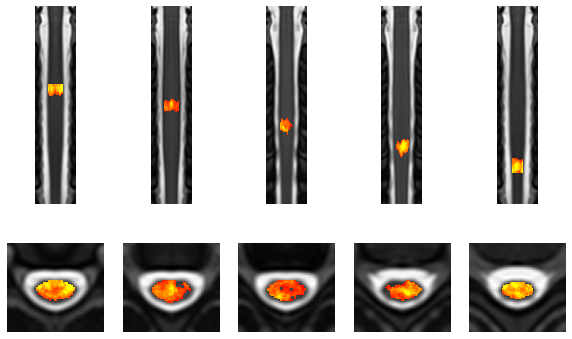

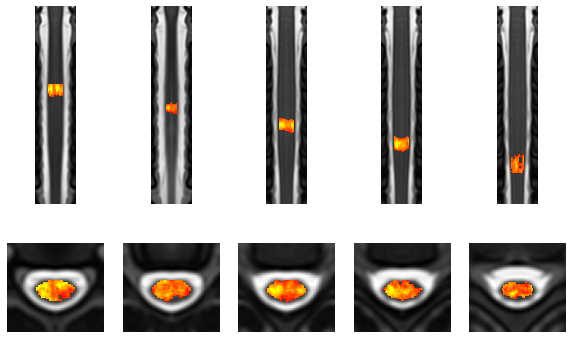

In [72]:
splits = ["quart1","quart2","quart3","quart4"]
dataset = 'gva'

for split in splits:
    params_qual_split_gva = {'k':(9 if dataset == 'mtl' else 5), 'dataset':dataset, 'analysis':'icap_duration', 'duration':split}
    plotting_split_gva = Plotting(config,'spinalcord',params1=params_qual_split_gva)
    plotting_split_gva.sc_plot(show_spinal_levels=False, k_per_line=(9 if dataset == 'mtl' else 5), lthresh=1.6, uthresh=3.5, save_results=True, similarity_method='Dice')

### Quantitative evaluation

/media/miplab-nas2/Data3/BMPD/hc_project//spine_only/gva/icap_duration/15min/K_5/comp_zscored/*iCAPs*
/media/miplab-nas2/Data3/BMPD/hc_project//spine_only/gva/icap_duration/quart1/K_5/comp_zscored/*iCAPs*
/media/miplab-nas2/Data3/BMPD/hc_project//spine_only/gva/icap_duration/quart2/K_5/comp_zscored/*iCAPs*
/media/miplab-nas2/Data3/BMPD/hc_project//spine_only/gva/icap_duration/quart3/K_5/comp_zscored/*iCAPs*
/media/miplab-nas2/Data3/BMPD/hc_project//spine_only/gva/icap_duration/quart4/K_5/comp_zscored/*iCAPs*
METHOD 3: Comparing sets of components across durations
0.8978981773443145  ±  0.04
0.8153155827822796  ±  0.1
0.9166158965582933  ±  0.03
0.8931913827477478  ±  0.04


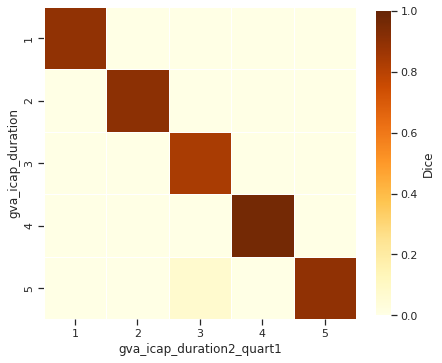

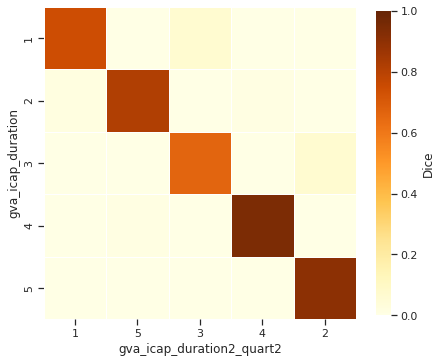

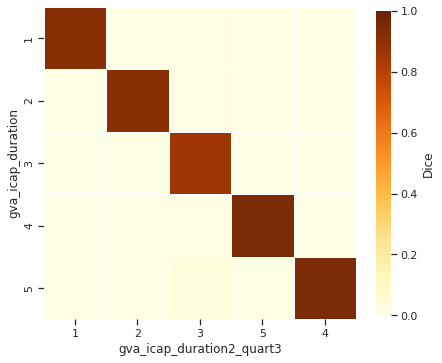

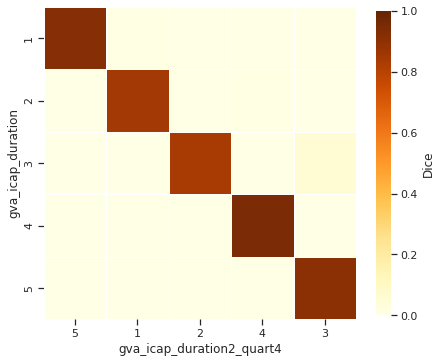

In [168]:
# Define parameters for the datasets to compare
# Each param dict has 3 values: k_range, dataset and analysis
dataset="gva"
t_range=["quart1","quart2","quart3","quart4"]

params_quant_split_gva_1 = {'k_range':range(5,6),'dataset':dataset, 'analysis':"icap_duration",'t_range':['15min'],'lthresh':1.6}
params_quant_split_gva_2 = {'k_range':range(5,6), 'dataset':dataset, 'analysis':"icap_duration", 't_range': t_range,'lthresh':1.6}

spine_analysis_split_gva = SpineOnlyAnalysis(config,params1=params_quant_split_gva_1,params2=params_quant_split_gva_2)
spine_analysis_split_gva.spatial_similarity(k1=5,t_range1='15min',t_range2=t_range,similarity_method='Dice',save_figure=True,verbose=False)

/media/miplab-nas2/Data3/BMPD/hc_project//spine_only/gva/icap_duration/15min/K_5/comp_zscored/*iCAPs*
/media/miplab-nas2/Data3/BMPD/hc_project//spine_only/gva/icap_duration/quart1/K_5/comp_zscored/*iCAPs*
/media/miplab-nas2/Data3/BMPD/hc_project//spine_only/gva/icap_duration/quart2/K_5/comp_zscored/*iCAPs*
/media/miplab-nas2/Data3/BMPD/hc_project//spine_only/gva/icap_duration/quart3/K_5/comp_zscored/*iCAPs*
/media/miplab-nas2/Data3/BMPD/hc_project//spine_only/gva/icap_duration/quart4/K_5/comp_zscored/*iCAPs*
METHOD 3: Comparing sets of components across durations
0.8978981773443145  ±  0.04
0.8153155827822796  ±  0.1
0.9166158965582933  ±  0.03
0.8931913827477478  ±  0.04


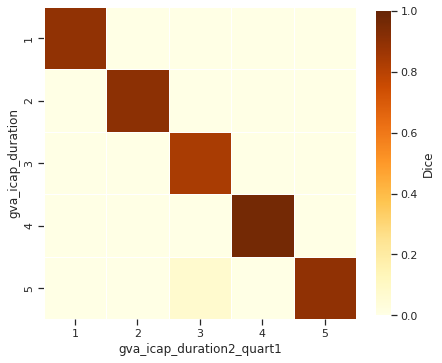

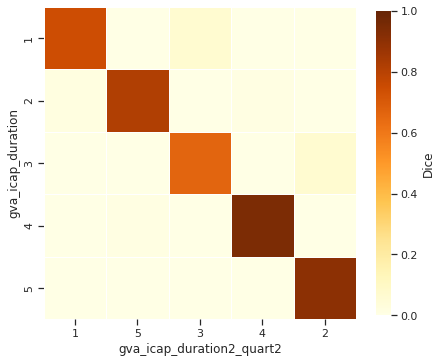

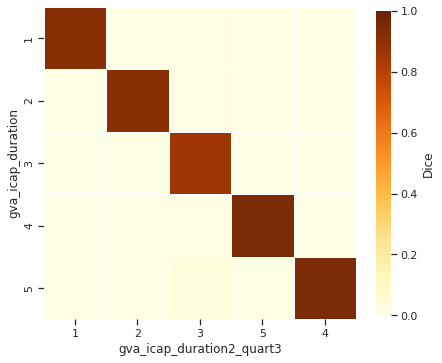

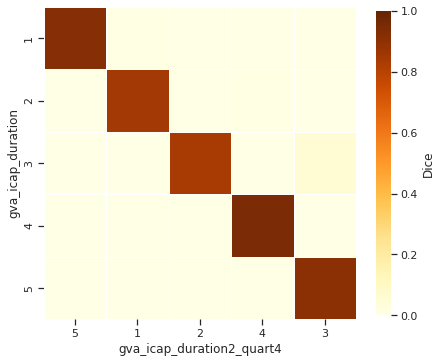

In [165]:
# Define parameters for the datasets to compare
# Each param dict has 3 values: k_range, dataset and analysis
dataset="gva"
t_range=["quart1","quart2","quart3","quart4"]

params_quant_split_gva_1 = {'k_range':range(5,6),'dataset':dataset, 'analysis':"icap_duration",'t_range':['15min'],'lthresh':1.6}
params_quant_split_gva_2 = {'k_range':range(5,6), 'dataset':dataset, 'analysis':"icap_duration", 't_range': t_range,'lthresh':1.6}

spine_analysis_split_gva = SpineOnlyAnalysis(config,params1=params_quant_split_gva_1,params2=params_quant_split_gva_2)
spine_analysis_split_gva.spatial_similarity(k1=5,t_range1='15min',t_range2=t_range,similarity_method='Dice',save_figure=True,verbose=False)

/media/miplab-nas2/Data3/BMPD/hc_project//spine_only/gva/ica_duration/all/K_5/comp_zscored/*4D_z*
/media/miplab-nas2/Data3/BMPD/hc_project//spine_only/gva/ica_duration/quart1/K_5/comp_zscored/*4D_z*
/media/miplab-nas2/Data3/BMPD/hc_project//spine_only/gva/ica_duration/quart2/K_5/comp_zscored/*4D_z*
/media/miplab-nas2/Data3/BMPD/hc_project//spine_only/gva/ica_duration/quart3/K_5/comp_zscored/*4D_z*
/media/miplab-nas2/Data3/BMPD/hc_project//spine_only/gva/ica_duration/quart4/K_5/comp_zscored/*4D_z*
METHOD 3: Comparing sets of components across durations
0.20688293941115  ±  0.11
0.48591322839387263  ±  0.14
0.44187703829433855  ±  0.09
0.24892265355806184  ±  0.18


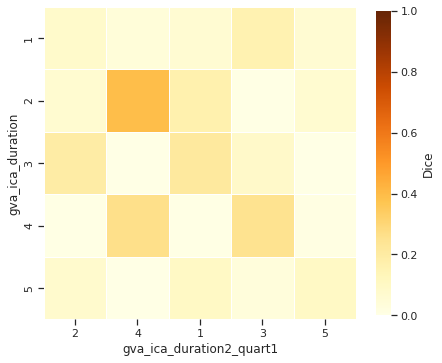

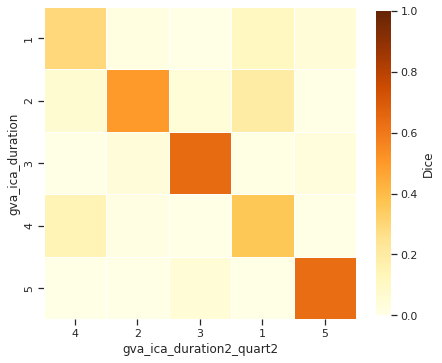

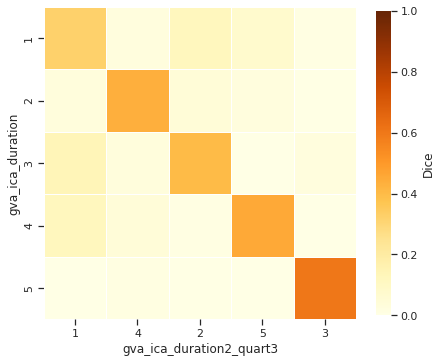

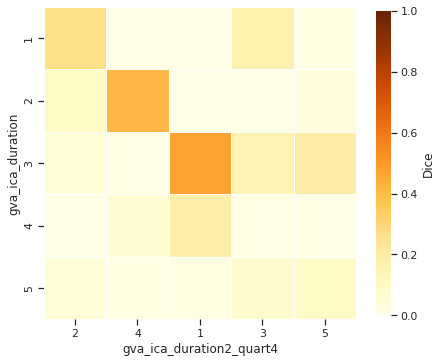

In [161]:
# Define parameters for the datasets to compare
# Each param dict has 3 values: k_range, dataset and analysis
dataset="gva"
t_range=["quart1","quart2","quart3","quart4"]

params_quant_split_gva_1 = {'k_range':range(5,6),'dataset':dataset, 'analysis':"ica_duration",'t_range':['all'],'lthresh':1.6}
params_quant_split_gva_2 = {'k_range':range(5,6), 'dataset':dataset, 'analysis':"ica_duration", 't_range': t_range,'lthresh':1.6}

spine_analysis_split_gva = SpineOnlyAnalysis(config,params1=params_quant_split_gva_1,params2=params_quant_split_gva_2)
spine_analysis_split_gva.spatial_similarity(k1=5,t_range1='all',t_range2=t_range,similarity_method='Dice',save_figure=True,verbose=False)

## `MTL` dataset

### Qualitative evaluation

Sorting method: rostrocaudal (max value)
The plotting will be displayed in neurological orientation (Left > Right)
Sorting method: rostrocaudal (max value)
The plotting will be displayed in neurological orientation (Left > Right)


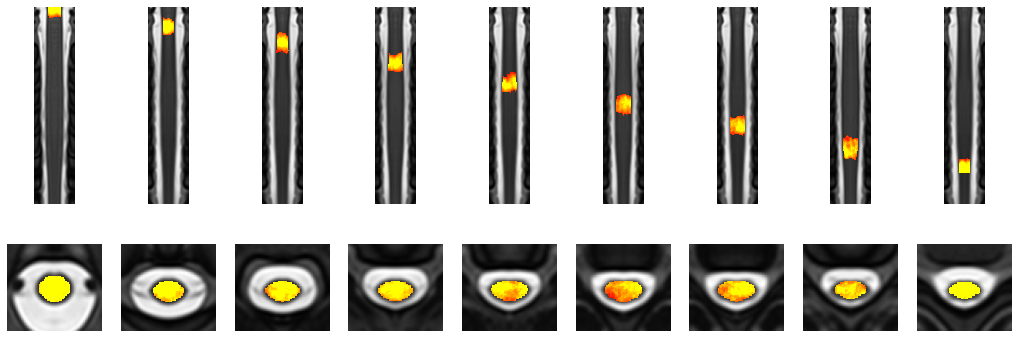

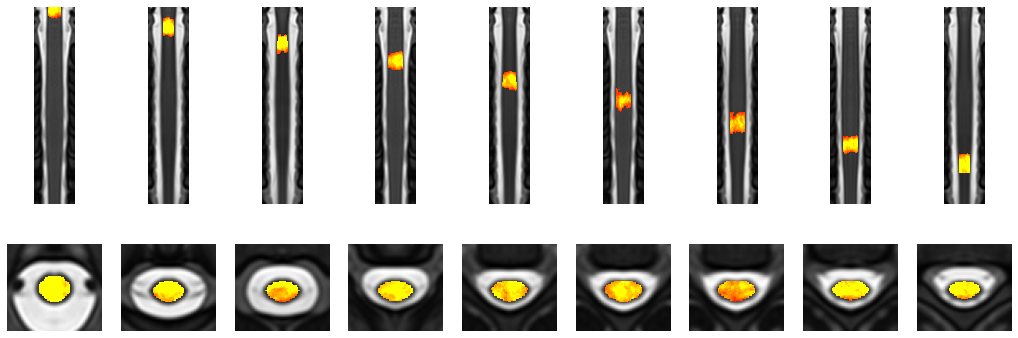

In [81]:
splits = ["half1","half2"]
dataset = 'mtl'

for split in splits:
    params_qual_split_gva = {'k':(9 if dataset == 'mtl' else 5), 'dataset':dataset, 'analysis':'icap_duration', 'duration':split}
    plotting_split_gva = Plotting(config,'spinalcord',params1=params_qual_split_gva)
    plotting_split_gva.sc_plot(show_spinal_levels=False, k_per_line=(9 if dataset == 'mtl' else 5), lthresh=1.6, uthresh=3.5, save_results=True, similarity_method='Dice')

### Quantitative evaluation

/media/miplab-nas2/Data3/BMPD/hc_project//spine_only/mtl/icap_duration/6min/K_9/comp_zscored/*iCAPs*
/media/miplab-nas2/Data3/BMPD/hc_project//spine_only/mtl/icap_duration/half1/K_9/comp_zscored/*iCAPs*
/media/miplab-nas2/Data3/BMPD/hc_project//spine_only/mtl/icap_duration/half2/K_9/comp_zscored/*iCAPs*
METHOD 3: Comparing sets of components across durations
0.9324720366827352  ±  0.04
0.9574016747406022  ±  0.02


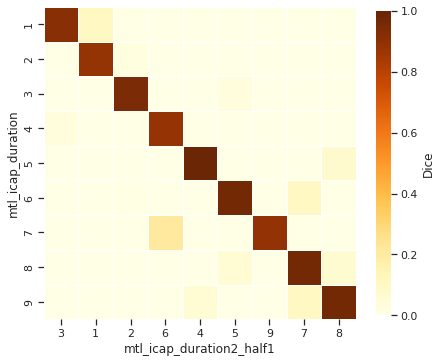

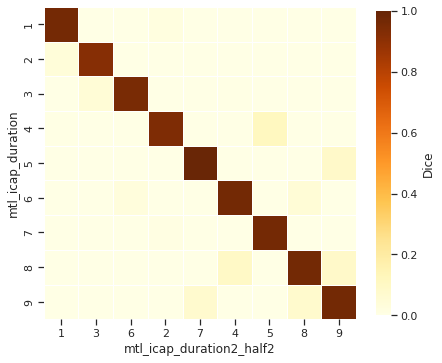

In [100]:
# Define parameters for the datasets to compare
# Each param dict has 3 values: k_range, dataset and analysis
dataset = 'mtl'
t_range=["half1","half2"]

params_quant_split_gva_1 = {'k_range':range(9,10),'dataset':dataset, 'analysis':"icap_duration",'t_range':['6min'],'lthresh':1.6}
params_quant_split_gva_2 = {'k_range':range(9,10), 'dataset':dataset, 'analysis':"icap_duration", 't_range': t_range,'lthresh':1.6}

spine_analysis_split_gva = SpineOnlyAnalysis(config,params1=params_quant_split_gva_1,params2=params_quant_split_gva_2)
spine_analysis_split_gva.spatial_similarity(k1=9,t_range1='6min',t_range2=t_range,similarity_method='Dice',verbose=False)

<hr style="border:1px solid black">

# Figure 5 – Subject-specific

## Qualitative evaluation
Here, we just display one example subject for each dataset, displayed on its own mean T2 image

### `GVA` dataset

In [ ]:
# Define parameters for the dataset to visualize
# Note: it is possible to look at a single dataset (in that case, just define params1), or to compare two (in that case, also add params2)
# Each param dict has 3 values: k, dataset and analysis

sub='07'
params_qual_1 = {'k':5, 'dataset':'gva', 'analysis':'icap', 'subject':sub,'lthresh':1.6}   

plotting = Plotting(config,'spinalcord',params1=params_qual_1,sorting_method='rostrocaudal')
plotting.sc_plot(show_spinal_levels=False, k_per_line=5, lthresh=1.6, uthresh=3.5, template=config['main_dir']+'spine_only/gva/sub-'+sub+'/sub-'+sub+'_anat2template_resampled.nii.gz',colormap_one='RdPu_r', save_results=True)

### `MTL` dataset

In [ ]:
# Define parameters for the dataset to visualize
# Note: it is possible to look at a single dataset (in that case, just define params1), or to compare two (in that case, also add params2)
# Each param dict has 3 values: k, dataset and analysis

subject = 'A011'
params_qual_1 = {'k':9, 'dataset':'mtl', 'analysis':'icap','lthresh':1.6}   
params_qual_2 = {'k':9, 'dataset':'mtl', 'analysis':'icap', 'subject':subject,'lthresh':1.6}   

plotting = Plotting(config,'spinalcord',params1=params_qual_1,params2=params_qual_2,sorting_method='rostrocaudal_CoM')
#plotting = Plotting(config,'spinalcord',params1=params_qual_1,sorting_method='rostrocaudal_CoM')
plotting.sc_plot(show_spinal_levels=False, k_per_line=9, lthresh=1.6, uthresh=3.5, template=config['main_dir']+'spine_only/mtl/sub-'+subject+'/sub-'+subject+'_T2w_coreg_in_PAM50_resampled.nii.gz', colormap_two=['gray','winter'], save_results=False)

In [ ]:
plotting = Plotting(config,'spinalcord',params1=params_qual_1,sorting_method='rostrocaudal_CoM')
plotting.sc_plot(show_spinal_levels=False, k_per_line=9, lthresh=1.6, uthresh=4, template=config['main_dir']+'spine_only/mtl/sub-'+subject+'/sub-'+subject+'_T2w_coreg_in_PAM50_resampled.nii.gz', colormap_one='winter', save_results=False)

## Heatmap of the distribution

In [ ]:
redo_distribution_map=False
if redo_distribution_map==True:
    for dataset in ["gva","mtl"]:
        for ana in ["ica","icap"]:
            params_heat_1 = {'k_range':(range(9,10) if dataset == 'mtl' else range(5,6)),'dataset':dataset, 'analysis':ana,'lthresh':1.6}   
            spine_analysis = SpineOnlyAnalysis(config,params1=params_heat_1,params2=params_heat_1,load_subjects=True)
            spine_analysis.subject_distribution(spine_analysis.name1, k=params_heat_1['k_range'][0])
            
save_plots=True
for dataset in ["mtl","gva"]:
    for ana in ["ica","icap"]:
        config["output_tag"]= "Distribution"
        config["data"][dataset][ana]["spinalcord"]["tag_filename"]=".nii.gz"
        params_qual_1 = {'k':(9 if dataset == 'mtl' else 5), 'dataset':dataset, 'analysis':ana, 'subject':"distribution"}
        plotting = Plotting(config,'spinalcord',params1=params_qual_1,params2=None,sorting_method='no_sorting')
        plotting.sc_plot(show_spinal_levels=False, k_per_line=params_qual_1['k'], lthresh=0, uthresh=len(config["list_subjects"][dataset]), save_results=save_plots,colormap_one='inferno')

with open('../config/config_spine_only_NK.json') as config_file:
    config = json.load(config_file)

In [ ]:
dataframe={};dataframe_comp={}
extract=True # put extract=True to extract the values 
for dataset in ["mtl","gva"]:
    dataframe[dataset]={};dataframe_comp[dataset]={}
    for ana in ["ica","icap"]:
        dataframe[dataset][ana]={};dataframe_comp[dataset][ana]={}
        for measure in ["Dice"]:
            config["output_dir"]= "/spine_only/results/individual_analyses/" + dataset + "/"+measure+"/"
            config["output_tag"]= "Indiv"
            
            if extract == True:
                params_quant_1 = {'k_range':(range(9,10) if dataset == 'mtl' else range(5,6)),'dataset':dataset, 'analysis':ana, 'lthresh':1.6}

                for sub in config['list_subjects'][dataset]:
                    params_quant_2 = {'k_range':(range(9,10) if dataset == 'mtl' else range(5,6)), 'dataset':dataset, 'analysis':ana, 'subject':'sub-'+sub, 'lthresh':1.6}

                spine_analysis = SpineOnlyAnalysis(config,params1=params_quant_1,params2=params_quant_2,load_subjects=True)
                print(params_quant_1["k_range"][0])
                spine_analysis.spatial_similarity(k1=params_quant_1["k_range"][0],k2=params_quant_2["k_range"][0],similarity_method='Dice',save_results=True,save_figure=False)

            input_comp= glob.glob(config["main_dir"] +config["output_dir"] + config["output_tag"] + "*_" +ana+ "_*indiv_comp.txt")[0]
            input= glob.glob(config["main_dir"] +config["output_dir"] + config["output_tag"] + "*_" +ana+ "_*indiv.txt")[0]
            
            dataframe_comp[dataset][ana][measure]=pd.read_csv(input_comp, header=0,sep=' ')
            dataframe[dataset][ana][measure]=pd.read_csv(input, header=0,sep=' ')
            
frames=[dataframe["mtl"]["ica"]["Dice"],dataframe["gva"]["ica"]["Dice"],dataframe["mtl"]["icap"]["Dice"],dataframe["gva"]["icap"]["Dice"]]; frames=pd.concat(frames)
frames_comp=[dataframe_comp["mtl"]["ica"]["Dice"],dataframe_comp["gva"]["ica"]["Dice"],dataframe_comp["mtl"]["icap"]["Dice"],dataframe_comp["gva"]["icap"]["Dice"]] ; frames_comp=pd.concat(frames_comp)

In [ ]:
#frames=[dataframe["mtl"]["ica"]["Dice"],dataframe["gva"]["ica"]["Dice"]]; frames=pd.concat(frames)

import seaborn as sns
colors=['#efb537','#20b5bf'] #'#273248'
sns.set(style="ticks",  font='sans-serif')
g=sns.catplot(y="Dice",x="dataset",data=frames, kind="box", hue="analysis", legend=True, legend_out=True,
             linewidth=2,medianprops=dict(color="white"),palette=colors, 
              boxprops=dict(alpha=.9),fliersize=0, aspect=1) #fliersize=0)
g.fig.set_size_inches(10,5)

sns.stripplot(x="dataset", y="Dice",data=frames, hue="analysis",
             size=6, palette=colors, linewidth=1,edgecolor='white',dodge=True)

g.set_axis_labels(" ", "Mean dice coefficient",fontsize=12, fontweight='bold')
g.set_xticklabels(["mtl dataset","gva dataset"],weight='bold',fontsize=12);


